In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Any
import sys
import copy
import matplotlib.pyplot as plt
import itertools
from fractions import Fraction
from decimal import Decimal

from src.dataclass import (
    Input, Lattice, Parameter, Train, Save,
    Processed_Input, Topology, Conjugate, Result
)

from src.manage_data import Data
from src.manage_data import (
    filter_df, get_correlation_length, get_label, load_result, load_setting, delete_result)

from src.plot import log_fit, log_log_line

In [2]:
# setting = load_setting()

# setting[setting["size"] == 20]
# setting

In [3]:
full_df = load_result("result") # load result from "result" or "temp" folder
full_df.columns.values

array(['key', 'state', 'size', 'dimension', 'ghost', 'initial', 'T', 'H',
       'Tc', 'Hc', 'Jm', 'Jv', 'mode', 'variable', 'multiply', 'base',
       'exponent', 'iteration', 'sweep', 'measurement', 'interval',
       'ensemble', 'max_workers', 'threshold', 'recent', 'environment',
       'save', 'order_parameter', 'susceptibility', 'binder_cumulant',
       'spin_glass_order', 'spin_glass_suscept', 'spin_glass_binder',
       'energy', 'specific_heat', 'irreducible_distance',
       'correlation_function', 'autocorrelation', 'time', 'location'],
      dtype=object)

In [4]:
# full_df

In [5]:
full_df.size/full_df.columns.values.size

1636.0

In [6]:
# delete = full_df[(full_df["state"] == 4) & (full_df["size"] == 8)]
# list(delete["key"])
# print(list(delete["key"]))

In [7]:
# delete_result("result", list(delete["key"]))

In [8]:
# df[(df["size"] == 8) & (df["Jv"] == 0.1)].sort_values("T", ascending=True)

In [20]:
state, dimension = (3, 2)

yt, yh, Tc = (Fraction(6,5), Fraction(28,15), 1.494)

alpha, beta, gamma, delta, nu, eta = (
    2-dimension/yt,
    (dimension-yh)/yt,
    (2*yh-dimension)/yt,
    yh/(dimension-yh),
    1/yt,
    dimension-2*yh+2,
)

print(f"{yt=}, {yh=}, {Tc=}")
print(f"{alpha=}, {beta=}, {gamma=}, {delta=}, {nu=}, {eta=}")

Jv = 0.0

#* Filter data at same universality class (identical state and dimension)
filtered_df = filter_df(full_df, state=state, dimension=dimension)
available_sizes = sorted(set(filtered_df["size"].values))
available_Jvs = sorted(set(filtered_df["Jv"].values))
print(available_sizes, available_Jvs)

# print(result[size_list.index(64),Jv_list.index(0.0)].order_parameter)

yt=Fraction(6, 5), yh=Fraction(28, 15), Tc=1.494
alpha=Fraction(1, 3), beta=Fraction(1, 9), gamma=Fraction(13, 9), delta=Fraction(14, 1), nu=Fraction(5, 6), eta=Fraction(4, 15)
[8, 16, 32, 64, 128] [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]


In [21]:
# filtered_df

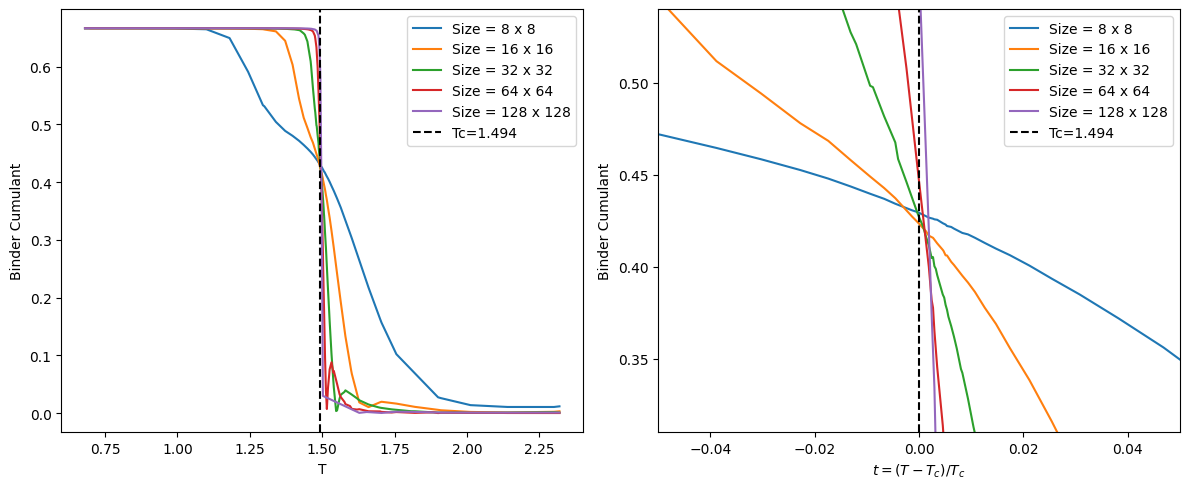

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# Query
# state, dimension, Jv = 3, 2, 0.0
filtered_df = filter_df(full_df, state=state, dimension=dimension, Jv=Jv)
available_sizes = sorted(set(filtered_df["size"].values))

# Main plot
for size in available_sizes:
    data = Data.from_df(filter_df(filtered_df, size=size))
    ax1.plot(data.temperature, data.binder_cumulant, label=get_label(data, "size"))
    ax2.plot((data.temperature - Tc) / Tc, data.binder_cumulant, label=get_label(data, "size"))

    x, y = data.temperature, data.binder_cumulant
    mask = y <= 1
    x, y = x[mask], y[mask]


# Additional lines
ax1.axvline(Tc, linestyle="--", color="k", label=f"Tc={Tc}")
ax2.axvline(0.0, linestyle="--", color="k", label=f"Tc={Tc}")

ax1.set_ylim([None, None])
ax1.legend()
ax1.set_xlabel("T")
ax1.set_ylabel("Binder Cumulant")
ax2.legend()
ax2.set_xlabel(r"$t=(T-T_c)/T_c$")
ax2.set_xlim([-0.05, 0.05])
ax2.set_ylim([0.31, 0.54])
ax2.set_ylabel("Binder Cumulant")

fig.tight_layout()

plt.show()

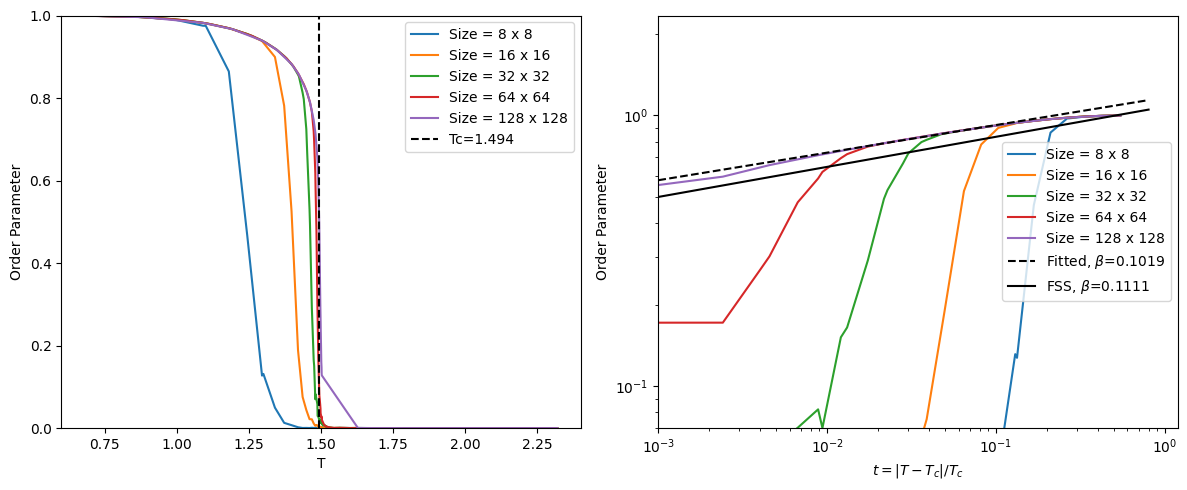

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# Query
# state, dimension, Jv = 3, 2, 0.0
filtered_df = filter_df(full_df, state=state, dimension=dimension, Jv=Jv)
available_sizes = sorted(set(filtered_df["size"].values))

for size in available_sizes:
    data = Data.from_df(filter_df(filtered_df, size=size))
    ax1.plot(data.temperature, data.order_parameter, label=get_label(data, "size"))
    ax2.plot((Tc-data.temperature) / Tc, data.order_parameter, label=get_label(data, "size"))

    # Fitting line at largest system size
    if size == max(available_sizes):
        x, y = (Tc-data.temperature) / Tc, data.order_parameter
        mask = (1e-2 < x) * (x < 1e-1)  # [False, False, ..... ,True, True, ...., False, False]
        fit_x, fit_y, slope, _ = log_fit(x[mask], y[mask], start=1e-3, end=8e-1)
        ax2.plot(fit_x, fit_y, "k--", label=fr"Fitted, $\beta$={slope:.4f}")

# Additional lines
ax1.axvline(Tc, linestyle="--", color="k", label=f"Tc={Tc}")

# guide line
x0, y0, slope, x1 = 1e-3, 5e-1, beta, 8e-1
log_log_line(x0, y0, float(slope), x1, ax2, label=fr"FSS, $\beta$={float(beta):.4f}", color="k")

ax1.set_ylim([0, 1])
ax1.legend()
ax1.set_xlabel("T")
ax1.set_ylabel("Order Parameter")

ax2.legend()
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_xlabel(r"$t=|T-T_c|/T_c$")
ax2.set_ylabel("Order Parameter")
ax2.set_xlim([1.e-3, None])
ax2.set_ylim([7.e-2, None])

fig.tight_layout()

plt.show()

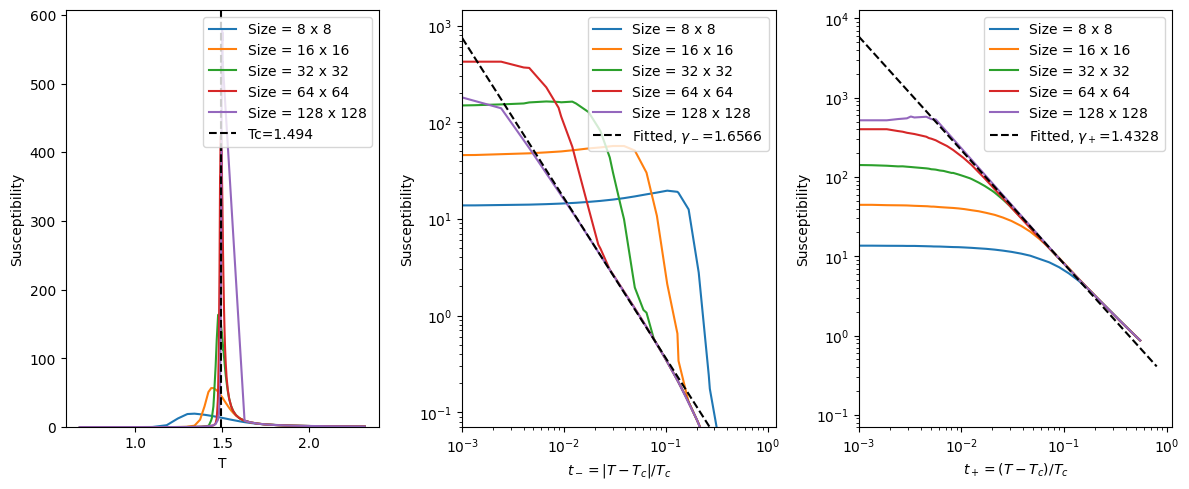

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))

# Query
# state, dimension, Jv = 3, 2, 0.0
filtered_df = filter_df(full_df, state=state, dimension=dimension, Jv=Jv)
available_sizes = sorted(set(filtered_df["size"].values))

for size in available_sizes:
    data = Data.from_df(filter_df(filtered_df, size=size))
    ax1.plot(data.temperature, data.susceptibility, label=get_label(data, "size"))
    ax2.plot((Tc-data.temperature) / Tc, data.susceptibility, label=get_label(data, "size"))
    ax3.plot((data.temperature-Tc) / Tc, data.susceptibility, label=get_label(data, "size"))

    # Fitting line at largest system size
    if size == max(available_sizes):
        x, y = (Tc-data.temperature) / Tc, data.susceptibility
        mask = (1e-2 < x) * (x < 1e-1)  # [False, False, ..... ,True, True, ...., False, False]
        fit_x, fit_y, slope, _ = log_fit(x[mask], y[mask], start=1e-3, end=8e-1)
        ax2.plot(fit_x, fit_y, "k--", label=fr"Fitted, $\gamma_-$={np.abs(slope):.4f}")
        
        x, y = (data.temperature-Tc) / Tc, data.susceptibility
        mask = (5*1e-3 < x) * (x < 1e-1)  # [False, False, ..... ,True, True, ...., False, False]
        fit_x, fit_y, slope, _ = log_fit(x[mask], y[mask], start=1e-3, end=8e-1)
        ax3.plot(fit_x, fit_y, "k--", label=fr"Fitted, $\gamma_+$={np.abs(slope):.4f}")        

# Additional lines
ax1.axvline(Tc, linestyle="--", color="k", label=f"Tc={Tc}")

# # guide line
# x0, y0, slope, x1 = 1e-3, 1e1, -gamma, 8e-1
# log_log_line(x0, y0, float(slope), x1, ax2, label=fr"FSS, $\gamma$={float(gamma):.4f}", color="k")
# x0, y0, slope, x1 = 1e-3, 1e1, -gamma, 8e-1
# log_log_line(x0, y0, float(slope), x1, ax3, label=fr"FSS, $\gamma$={float(gamma):.4f}", color="k")

ax1.set_ylim([0, None])
ax1.legend()
ax1.set_xlabel("T")
ax1.set_ylabel("Susceptibility")

ax2.legend()
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_xlabel(r"$t_-=|T-T_c|/T_c$")
ax2.set_ylabel("Susceptibility")
ax2.set_xlim([1.e-3, None])
ax2.set_ylim([7.e-2, None])

ax3.legend()
ax3.set_yscale("log")
ax3.set_xscale("log")
ax3.set_xlabel(r"$t_+=(T-T_c)/T_c$")
ax3.set_ylabel("Susceptibility")
ax3.set_xlim([1.e-3, None])
ax3.set_ylim([7.e-2, None])

fig.tight_layout()

plt.show()

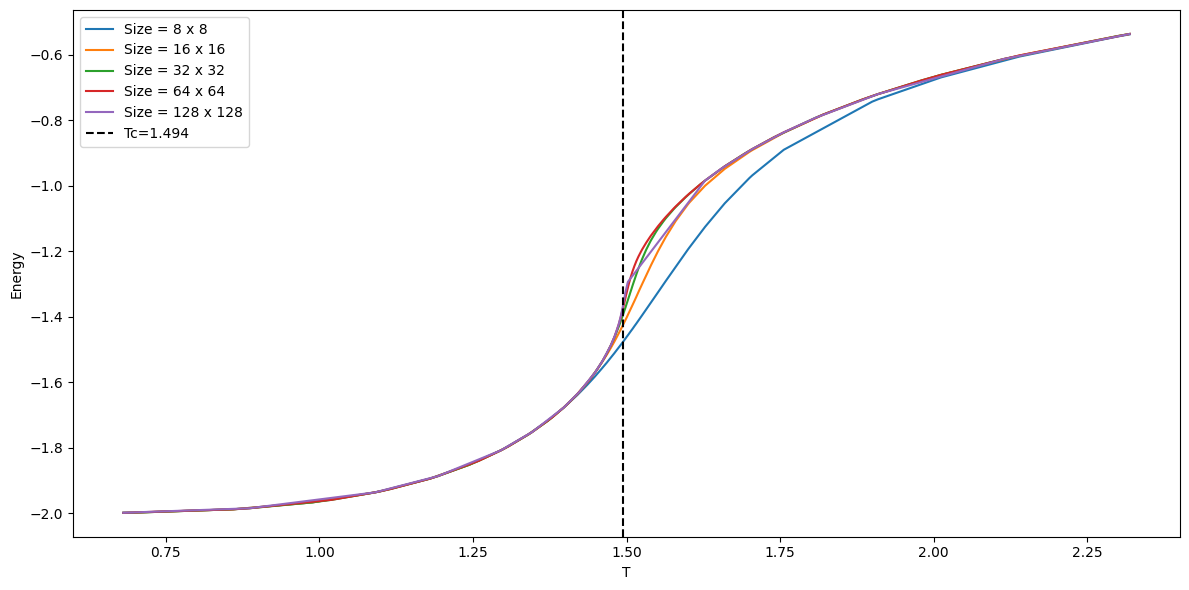

In [25]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))

# Query
# state, dimension, Jv = 4, 3, 0.0
filtered_df = filter_df(full_df, state=state, dimension=dimension, Jv=Jv)
available_sizes = sorted(set(filtered_df["size"].values))

for size in available_sizes:
    data = Data.from_df(filter_df(filtered_df, size=size))
    ax.plot(data.temperature, data.energy, label=get_label(data, "size"))

# Additional lines
ax.axvline(Tc, linestyle="--", color="k", label=f"Tc={Tc}")
# ax.set_ylim([0, None])
ax.legend()
ax.set_xlabel("T")
ax.set_ylabel("Energy")

fig.tight_layout()

plt.show()

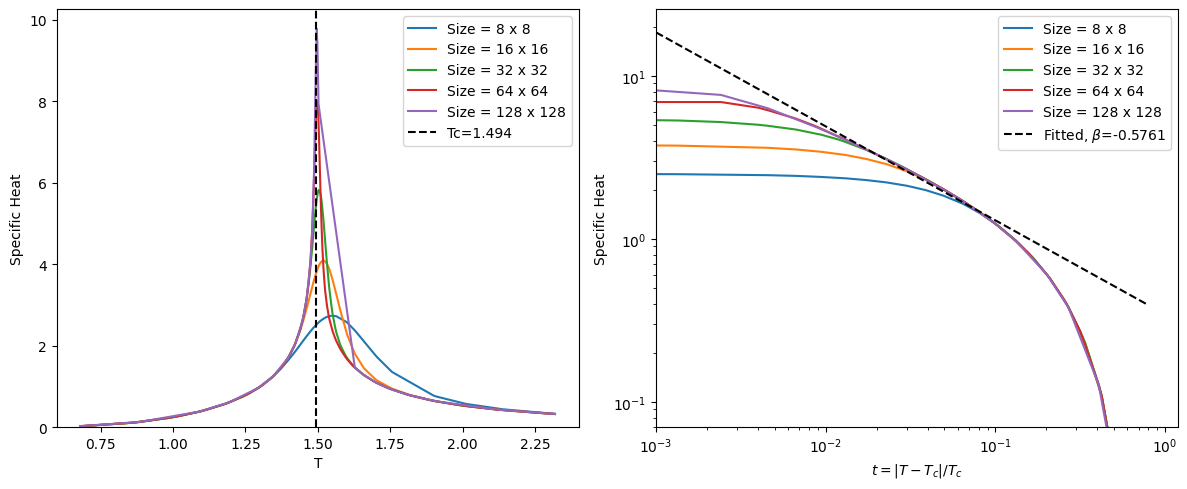

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# Query
# state, dimension, Jv = 4, 3, 0.0
filtered_df = filter_df(full_df, state=state, dimension=dimension, Jv=Jv)
available_sizes = sorted(set(filtered_df["size"].values))

for size in available_sizes:
    data = Data.from_df(filter_df(filtered_df, size=size))
    ax1.plot(data.temperature, data.specific_heat, label=get_label(data, "size"))
    ax2.plot((Tc-data.temperature) / Tc, data.specific_heat, label=get_label(data, "size"))

    # Fitting line at largest system size
    if size == max(available_sizes):
        x, y = (Tc-data.temperature) / Tc, data.specific_heat
        mask = (1e-2 < x) * (x < 1e-1)  # [False, False, ..... ,True, True, ...., False, False]
        fit_x, fit_y, slope, _ = log_fit(x[mask], y[mask], start=1e-3, end=8e-1)
        ax2.plot(fit_x, fit_y, "k--", label=fr"Fitted, $\beta$={slope:.4f}")

# Additional lines
ax1.axvline(Tc, linestyle="--", color="k", label=f"Tc={Tc}")

# # guide line
# x0, y0, slope, x1 = 1e-3, 5e-1, beta, 8e-1
# log_log_line(x0, y0, float(slope), x1, ax2, label=fr"FSS, $\beta$={float(beta):.4f}", color="k")

ax1.set_ylim([0, None])
ax1.legend()
ax1.set_xlabel("T")
ax1.set_ylabel("Specific Heat")

ax2.legend()
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_xlabel(r"$t=|T-T_c|/T_c$")
ax2.set_ylabel("Specific Heat")
ax2.set_xlim([1.e-3, None])
ax2.set_ylim([7.e-2, None])

fig.tight_layout()

plt.show()

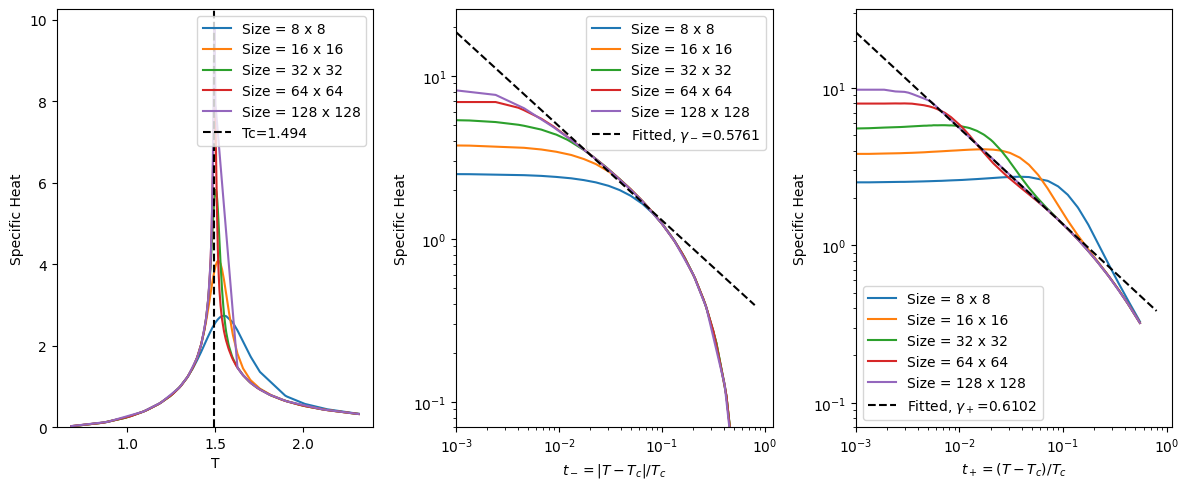

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))

# Query
# state, dimension, Jv = 2, 3, 0.0
filtered_df = filter_df(full_df, state=state, dimension=dimension, Jv=Jv)
available_sizes = sorted(set(filtered_df["size"].values))

for size in available_sizes:
    data = Data.from_df(filter_df(filtered_df, size=size))
    result = data.specific_heat
    
    ax1.plot(data.temperature, result, label=get_label(data, "size"))
    ax2.plot((Tc-data.temperature) / Tc, result, label=get_label(data, "size"))
    ax3.plot((data.temperature-Tc) / Tc, result, label=get_label(data, "size"))

    # Fitting line at largest system size
    if size == max(available_sizes):
        x, y = (Tc-data.temperature) / Tc, result
        mask = (1e-2 < x) * (x < 1e-1)  # [False, False, ..... ,True, True, ...., False, False]
        fit_x, fit_y, slope, _ = log_fit(x[mask], y[mask], start=1e-3, end=8e-1)
        ax2.plot(fit_x, fit_y, "k--", label=fr"Fitted, $\gamma_-$={np.abs(slope):.4f}")
        
        x, y = (data.temperature-Tc) / Tc, result
        mask = (5*1e-3 < x) * (x < 1e-1)  # [False, False, ..... ,True, True, ...., False, False]
        fit_x, fit_y, slope, _ = log_fit(x[mask], y[mask], start=1e-3, end=8e-1)
        ax3.plot(fit_x, fit_y, "k--", label=fr"Fitted, $\gamma_+$={np.abs(slope):.4f}")        

# Additional lines
ax1.axvline(Tc, linestyle="--", color="k", label=f"Tc={Tc}")

# # guide line
# x0, y0, slope, x1 = 1e-3, 1e1, -gamma, 8e-1
# log_log_line(x0, y0, float(slope), x1, ax2, label=fr"FSS, $\gamma$={float(gamma):.4f}", color="k")
# x0, y0, slope, x1 = 1e-3, 1e1, -gamma, 8e-1
# log_log_line(x0, y0, float(slope), x1, ax3, label=fr"FSS, $\gamma$={float(gamma):.4f}", color="k")

ax1.set_ylim([0, None])
ax1.legend()
ax1.set_xlabel("T")
ax1.set_ylabel("Specific Heat")

ax2.legend()
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_xlabel(r"$t_-=|T-T_c|/T_c$")
ax2.set_ylabel("Specific Heat")
ax2.set_xlim([1.e-3, None])
ax2.set_ylim([7.e-2, None])

ax3.legend()
ax3.set_yscale("log")
ax3.set_xscale("log")
ax3.set_xlabel(r"$t_+=(T-T_c)/T_c$")
ax3.set_ylabel("Specific Heat")
ax3.set_xlim([1.e-3, None])
ax3.set_ylim([7.e-2, None])

fig.tight_layout()

plt.show()

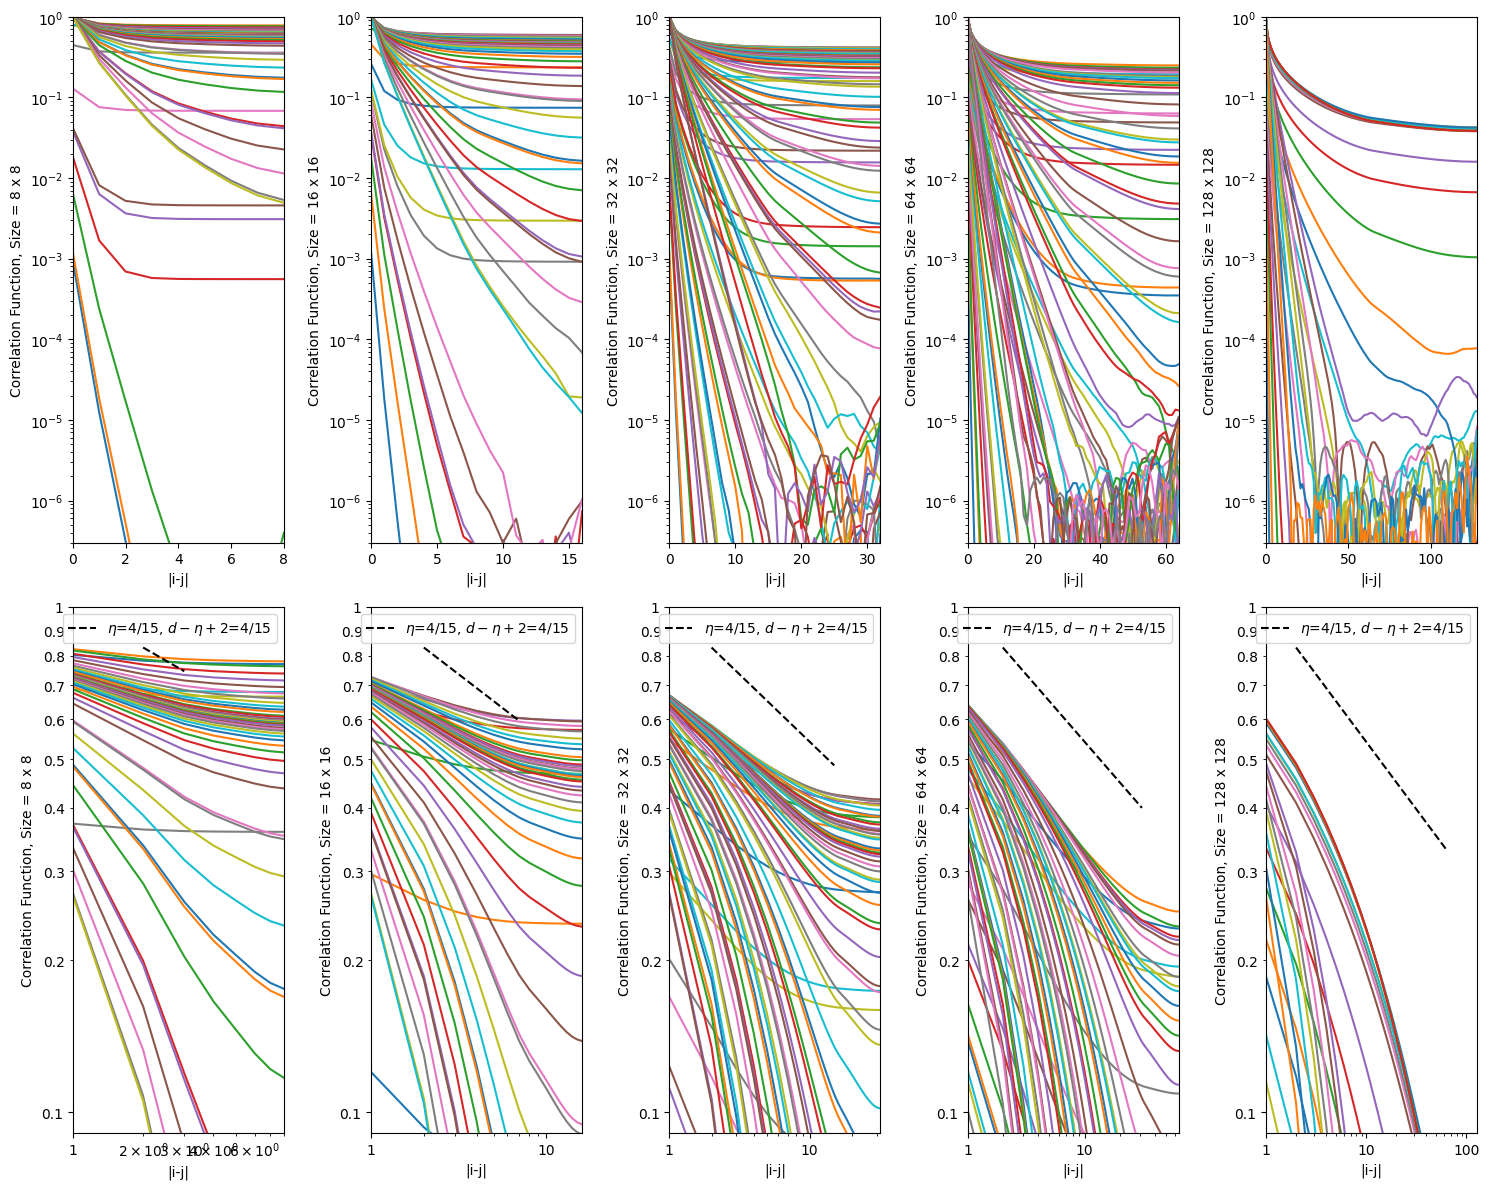

In [29]:
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda y, _: "{:.8g}".format(y))

# Query
# state, dimension, Jv = 2, 3, 0.0
filtered_df = filter_df(full_df, state=state, dimension=dimension, Jv=Jv)
available_sizes = sorted(set(filtered_df["size"].values))

fig, ax = plt.subplots(nrows=2, ncols=np.size(available_sizes), figsize=(15, 12))

for i, size in enumerate(available_sizes):
    data = Data.from_df(filter_df(filtered_df, size=size))
    
    for j, irr_dist in enumerate(data.irreducible_distance):
        ax[0,i].plot(irr_dist, data.correlation_function[j])
        ax[1,i].plot(irr_dist, data.correlation_function[j])
    
    def g(x):
        return 1/x**(dimension-2+eta)
    x = np.arange(2,data.size/2)
    ax[1,i].plot(x,g(x),"--",color="k", label=fr"$\eta$={eta}, $d-\eta+2$={dimension-2+eta}")

    ax[0,i].set_yscale("log")
    ax[0,i].set_xlim(0, data.size*data.dimension/2)
    ax[0,i].set_ylim(3.e-7, 1.)
    ax[0,i].set_xlabel("|i-j|")
    ax[0,i].set_ylabel(f"Correlation Function, {get_label(data, 'size')}")
    
    ax[1,i].loglog()
    ax[1,i].set_xlim(1, data.size*data.dimension/2)
    ax[1,i].set_ylim(0.091, 1.)
    ax[1,i].legend(loc="best")
    ax[1,i].set_xlabel("|i-j|")
    ax[1,i].set_ylabel(f"Correlation Function, {get_label(data, 'size')}")
    
    ax[1,i].xaxis.set_major_formatter(formatter)
    # ax[1,i].xaxis.set_minor_formatter(formatter)
    ax[1,i].yaxis.set_major_formatter(formatter)
    ax[1,i].yaxis.set_minor_formatter(formatter)

fig.tight_layout()

# plt.legend()
plt.show()

In [ ]:
Jv = 0.0

for data in result[:, Jv_list.index(Jv)]:
    data.correlation_length = get_correlation_length(data)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

for data in result[size_list.index(16):size_list.index(20)+1, Jv_list.index(Jv)]:
    ax[0].plot(data.temperature, data.correlation_length, label=get_label(data, "size"))
    ax[1].plot((Tc-data.temperature)/Tc, data.correlation_length, label=get_label(data, "size"))
    ax[2].plot((data.temperature-Tc)/Tc, data.correlation_length, label=get_label(data, "size"))

ax[0].vlines(Tc, 0, 30, linestyle="--", color="k", label=f"Tc={Tc}")

def g(x):
    return x**(-nu)
x = np.linspace(0.0001, 1, 100)
ax[1].plot(x, g(x), "--", color="k", label = fr"$\nu$={nu}")
ax[2].plot(x, g(x), "--", color="k", label = fr"$\nu$={nu}")

ax[0].legend(loc="best")
ax[0].set_ylim([0, None])
ax[0].set_xlabel("T")
ax[0].set_ylabel("Correlation Length")

ax[1].legend(loc="best")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_xlabel(r"$t_-=|T-T_c|/T_c$")
ax[1].set_ylabel("Correlation Length")
ax[1].set_xlim([1.e-3, None])
ax[1].set_ylim([3.e-2, None])

ax[2].legend(loc="best")
ax[2].set_yscale("log")
ax[2].set_xscale("log")
ax[2].set_xlabel(r"$t_+=(T-T_c)/T_c$")
ax[2].set_ylabel("Correlation Length")
ax[2].set_xlim([1.e-3, None])
ax[2].set_ylim([3.e-2, None])

plt.legend()
plt.show()

In [ ]:
# x_min, x_max = (1, size/max(16/np.sqrt(size),8))

# measure_eta = []

# for i, distance_list in enumerate(np.array(corr["irreducible_distance"])):
#     correlation = np.array(corr["correlation_function"])[i]
#     x, y = [], []
#     for j, distance in enumerate(distance_list):
#         if(x_min <= distance <= x_max):
#             x.append(np.log(distance))
#             y.append(np.log(correlation[j]))
    
#     x, y = np.array(x).reshape((-1, 1)), np.array(y)
    
#     # print(x, y)
#     model = LinearRegression().fit(x, y)
#     measure_eta.append(2-dimension-model.coef_)

# measure_eta = np.average(measure_eta)

# print(f"measure eta = {measure_eta}")
# print(f"real eta: {eta}")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

size = 16

for data in result[size_list.index(size), :]:
    ax[0].plot(data.temperature, data.binder_cumulant, label=get_label(data, "Jv"))
    ax[1].plot(data.temperature, data.spin_glass_binder, label=get_label(data, "Jv"))
    
ax[0].vlines(Tc, 0, 0.7, linestyle="--", color="k", label=f"Tc={Tc}")
# ax[1].vlines(0, 0, 0.7, linestyle="--", color="k", label=f"Tc={Tc}")

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel("T")
ax[0].set_ylabel("Binder Cumulant")
ax[1].legend(loc="best")
ax[1].set_xlabel(r"$t=(T-T_c)/T_c$")
# ax[1].set_xlim([-0.05, 0.05])
# ax[1].set_ylim([0.31, 0.54])
ax[1].set_ylabel("Spin Glass Binder Cumulant")

plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

size = 16

for data in result[size_list.index(size), :]:
    ax[0].plot(data.temperature, data.order_parameter, label=get_label(data, "Jv"))
    ax[1].plot(data.temperature, data.spin_glass_order, label=get_label(data, "Jv"))

ax[0].vlines(Tc, 0, 1, linestyle="--", color="k", label=f"Tc={Tc}")

def g(x):
    return x**(beta)
x = np.linspace(0.0001, 1, 100)
# ax[1].plot(x, g(x), "--", color="k", label = fr"$\beta$={beta}")

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel("T")
ax[0].set_ylabel("Order Parameter")

ax[1].legend(loc="best")
# ax[1].set_yscale("log")
# ax[1].set_xscale("log")
# ax[1].set_xlabel(r"$t=|T-T_c|/T_c$")
ax[1].set_xlabel("T")
ax[1].set_ylabel("Spin Glass Order Parameter")
# ax[1].set_xlim([1.e-3, None])
ax[1].set_ylim([0, None])

plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

size = 16

for data in result[size_list.index(size), :]:
    ax[0].plot(data.temperature, data.susceptibility, label=get_label(data, "Jv"))
    ax[1].plot(data.temperature, data.spin_glass_suscept, label=get_label(data, "Jv"))

ax[0].vlines(Tc, 0, 5, linestyle="--", color="k", label=f"Tc={Tc}")

def g(x):
    return x**(-gamma)
x = np.linspace(0.0001, 1, 10)
# ax[1].plot(x, g(x), "--", color="k", label = fr"$\gamma$={gamma}")
# ax[2].plot(x, g(x), "--", color="k", label = fr"$\gamma$={gamma}")

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel("T")
ax[0].set_ylabel("Susceptibility")

ax[1].legend(loc="best")
# ax[1].set_yscale("log")
# ax[1].set_xscale("log")
ax[1].set_xlabel(r"$t_-=|T-T_c|/T_c$")
ax[1].set_ylabel("Spin Glass Susceptibility")
# ax[1].set_xlim([1.e-3, None])
ax[1].set_ylim([0.e-2, None])

plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

size = 16

for data in result[size_list.index(size), :]:
    ax.plot(data.temperature, data.energy, label=get_label(data, "Jv"))

ax.vlines(Tc, -2, -0.5, linestyle="--", color="k", label=f"Tc={Tc}")

# ax.set_ylim([-2, None])
ax.legend(loc="best")
ax.set_xlabel("T")
ax.set_ylabel("Energy")

plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

size = 16

for data in result[size_list.index(size), :]:
    ax.plot(data.temperature, data.specific_heat, label=get_label(data, "Jv"))

ax.vlines(Tc, 0, 5, linestyle="--", color="k", label=f"Tc={Tc}")


ax.set_ylim([0, None])
ax.legend(loc="best")
ax.set_xlabel("T")
ax.set_ylabel("Specific heat")

plt.show()